In [13]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt 


from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20



Query the CRTS DR2 http://nesssi.cacr.caltech.edu/cgi-bin/getcssconedbid_release2.cgi  , against ID , RA 196.38756	DEC, -10.5554	rad 0.002 arcmin. Two objects are released, CSS_J130533.0-103319  (234 epochs) MLS_J130533.0-103319 (56 epochs).  

In [2]:
# read in the PG 1302 data....
data = Table.read('../raw_CRTS_data/PG1302-102_LC.csv', format='ascii')
data.sort('MJD')
y = data['Mag']
yerr = data['Magerr']
t = data['MJD']




Calculate moving-average $\chi^{2}_{DOF}$  :



In [4]:
def calcChi2raw(y, yerr):
    """Compute simple reduced chi2  (mean-based) if more than 1 datapoints present
    chi2 = np.sum(((flux-meanFlux)**2.0) / (fluxErr ** 2.0)) / (N-1.0)
    """
    N = len(y)
    if N < 2:
        return np.nan
    else:
        chi2 = np.sum(((y-np.mean(y))/yerr)**2)
        return chi2/(N-1)
    
def calcWeightedMean(y,yerr):
    ''' Calculate the weighted mean '''
    N = len(y)
    if N == 1 : 
        return float(y)    
    elif N == 0 : 
        return np.nan
    else: 
        # weights = 1 / (yerr ** 2.0)  
        # wMean = np.sum(weights * flux) / np.sum(weights)
        return float(np.add.reduce(y / (yerr * yerr)) / np.add.reduce((1/yerr)*(1/yerr)))
    
N = len(y)
wMean = calcWeightedMean(y,yerr)
chi2dof  = (1 / (N-1.0)) * np.sum(((y- wMean)/yerr)**2)



In [153]:
% matplotlib inline 

def sliding_window_statistics(t,y,yerr, window_width=500, f_offset = 0.5, save_fig=None, fig_name=None, 
                              return_results=None, outDir = None):
    '''
    A simple function to calculate sliding window stats, and plot them. By default, no dictionary 
    with results is returned. 
    
    Required parameters:
    ---------------------
    t : the obs time 
    y : the flux measurement
    yerr : the flux error 
    
    
    
    By sliding window we mean  a span of data between  t1 and t2,  such that 
    t1 < t < t2 . We calculate in the store dictionary :
    - chi2dof_window :  chi2 per degree of freedom based on the weighted mean
    and provided raw photometric errors,   
    - N_pts_window : the number of points contained in the window 
    - t_center_window : the middle of the window (note : this is not  mean(t),  but (t2-t1) / 2)
    - t_window_mean : just for comparison, the mean t of the window (data based )
    - wMean_window : the weighted mean of the flux measurement (y)
    
    Returns:
    ---------
    
    store{} : a dictionary (if return_results != None)
    
    '''
    
    
    # set up window size , sliding step..... 
    window_width = 500 # days 
    offset = f_offset * window_width
    t0 = min(t) - offset

    window_slide_step_size=  5 #  days 
    window_frame_start = np.arange(t0, max(t), window_slide_step_size)
    window_frame_end = window_frame_start + window_width

    # calculate the  sliding window statistics 
    N_windows = len(window_frame_start)

    store = {'N_pts_window':np.zeros(N_windows), 't_center_window':np.zeros(N_windows), 
          't_window_mean':np.zeros(N_windows), 'wMean_window':np.zeros(N_windows),
            'chi2dof_window':np.zeros(N_windows)}

    for i in range(N_windows) :
        mask_in_window = ( window_frame_start[i] < t)  * (t < window_frame_end[i])
        t_window = t[mask_in_window]
        y_window = y[mask_in_window]
        yerr_window = yerr[mask_in_window]

        N_pts_window = float(len(t_window))
        store['N_pts_window'][i] = N_pts_window
        store['t_center_window'][i] = (window_frame_end[i] + window_frame_start[i]) / 2.0
        store['t_window_mean'][i] = np.mean(t_window)
        wMean_window = calcWeightedMean(y_window, yerr_window)
        store['wMean_window'][i] = wMean_window
        store['chi2dof_window'][i] = (1 / (N_pts_window-1.0)) * np.sum(((y_window- wMean_window)/yerr_window)**2)


    print('Using %d windows of width %d days each , with the window sliding step of  %d days'%(N_windows, 
                                                            window_width, window_slide_step_size ) )
    # plot  : 
    # ax[0] : the lightcurve
    # ax[1] : count of points per window 
    # ax[2] : t_center_window vs wMean_window
    # ax[3] : chi2dof_window
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=( 10,10 ))   # (x_size , y_size)
    ax = dict()
    number_of_rows = 5
    number_of_columns = 1
    gs = gridspec.GridSpec(number_of_rows,  number_of_columns)
    ax[0] = plt.subplot(gs[:2, :])  # span all rows but the last one (bottom), and first 5 col
    ax[1] = plt.subplot(gs[2, :])  # span all rows but the last one (bottom), and last 5 cols
    ax[2] = plt.subplot(gs[3, :])  # span both rows, only second col
    ax[3] = plt.subplot(gs[4, :])

    fig.subplots_adjust(hspace=0.4)

    # lightcurve
    ax[0].scatter(t,y, lw=0, s=20, c='red')
    ax[0].errorbar(t, y, yerr, ls='None', alpha=0.5) 
    ax[0].set_ylabel('mag')
    size = 10

    # show an example window size...
    ax[0].axvline(window_frame_start[0], ls='--', color='magenta',lw=2)
    ax[0].axvline(window_frame_end[0],ls='--', color='magenta', lw=2)

    # overplot the mean....
    ax[0].scatter(store['t_center_window'], store['wMean_window'], s=size, lw=0, color='green')

    # count of points per window
    #ax[1].plot(store['t_center_window'],store['N_pts_window'], ls = 'steps')
    ax[1].scatter(store['t_center_window'],store['N_pts_window'], s=size, lw=0)
    ax[1].set_ylabel('N')

    # t_center_window vs wMean_window
    ax[2].scatter(store['t_center_window'], store['wMean_window'], s=size, lw=0, color='green')
    ax[2].set_ylabel(r'$\langle mag \rangle$')

    # chi2dof_window
    ax[3].scatter(store['t_center_window'], store['chi2dof_window'], s=size, lw=0)
    ax[3].set_ylabel(r'$\chi^{2}_{DOF}$')

    # move xlims of each plot so that they all start in the same place...
    xlim = ax[0].get_xlim()
    for i in range(1,len(ax)):
        ax[i].set_xlim(xlim)

    # remove edge xticks
    for i in range(len(ax)):
        xticks = ax[i].get_xticks()
        ax[i].set_xticks(xticks[1:-1])

    # make second axis start at 0 
    ax[1].set_ylim(0,)

    # make second axis ticks more rare 
    yticks = ax[1].get_yticks()
    ax[1].set_yticks(yticks[::2])
    
    # make third axis ticks more rare 
    yticks = ax[2].get_yticks()
    ax[2].set_yticks(yticks[::2])
    
    # make last axis start at 0 
    #ax[3].set_ylim(0,)

    # make last axis yticks more rare
    yticks = ax[3].get_yticks()
    ax[3].set_yticks(yticks[::2])

    # Save the figure...
    if save_fig is not None  : 
        if OutDir is None :
            OutDir = '../data_products/Fig_6_data/'
        if fig_name is None : 
            fname='PG1302-102'+'_win_'+str(window_width)+'_days.png'
        else:
            fname = fig_name
        plt.tight_layout()
        plt.savefig(OutDir+fname)
        print('Saved this plot as %s'%(OutDir+fname))
    # if desired, return the output
    if return_results is not None  :
        return store 

Using 640 windows of width 500 days each , with the window sliding step of  5 days


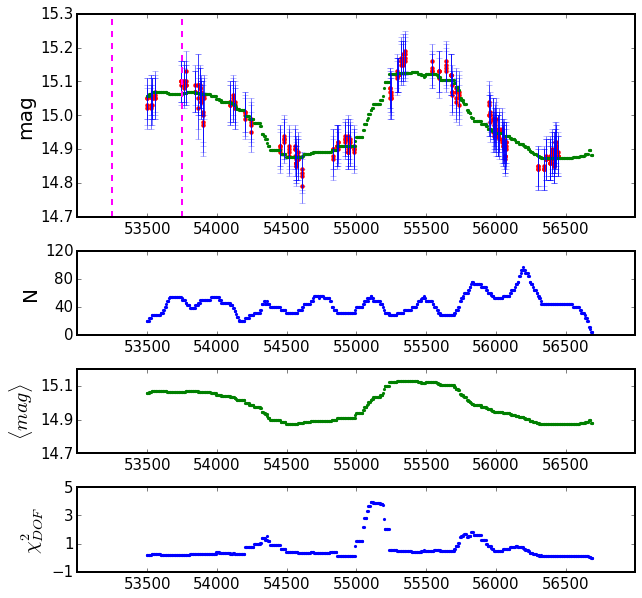

In [154]:
sliding_window_statistics(t,y,yerr, outDir=outDir)

## Apply to a few bright and faint QSO and stars : 

In [57]:
## Read in few quasars : choose one bright, well-sampled QSO, and one faint, same for stars . 

# Load the cross-matched CRTS-SDSS summary table : 
address = '../data_products/CRTS_SDSS_combined_QSO_catalog.dat'
sdss_crts = Table.read(address, format='ascii')



In [60]:
np.ravel(sdss_crts.colnames)

array(['raw_timespan_obs', 'raw_mean_err', 'raw_lc_length', 'raw_mean_mag',
       'CRTS_name', 'proc_mean_N_day', 'proc_lc_length', 'proc_mean_mag',
       'proc_mjd_span', 'proc_mean_err', 'proc_median_dt', 'ra_CRTS',
       'dec_CRTS', 'dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr',
       'redshift', 'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au',
       'match_angle_arcsec'], 
      dtype='<U18')

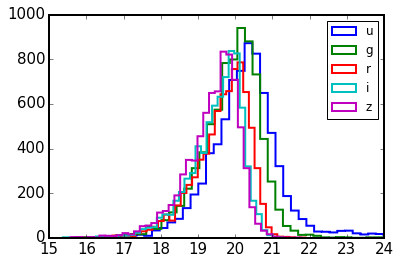

In [74]:
for f in 'ugriz' : 
    plt.hist(sdss_crts[f][(sdss_crts[f]>10)*(sdss_crts[f]<24)], histtype='step', lw=2, label=f, bins=40)
plt.legend()

In [75]:
# Choose two QSO: 

bright_QSO = sdss_crts[(sdss_crts['g'] > 15)*( sdss_crts['g'] < 16)]
# 235156.12-010913.3   has 404 points... 

faint_QSO = sdss_crts[sdss_crts['g']>20]

In [113]:
faint_QSO.sort('raw_lc_length')
faint_long_QSO = faint_QSO[-10:-1]

In [86]:
# Read in stars ...
address = '../data_products/CRTS_SDSS_combined_stars_catalog.dat'
stars = Table.read(address, format='ascii') 

In [87]:
np.ravel(stars.colnames)

array(['raw_mjd_span', 'raw_mean_mag', 'raw_mean_err', 'CRTS_name',
       'raw_lc_length', 'proc_mean_N_day', 'proc_mean_err',
       'proc_lc_length', 'proc_mean_mag', 'proc_mjd_span', 'ra_1', 'dec_1',
       'calib_fla', 'ra_2', 'dec_2', 'raRMS', 'decRMS', 'nEpochs',
       'AR_val', 'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt',
       'u_chi2', 'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt',
       'g_chi2', 'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt',
       'r_chi2', 'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt',
       'i_chi2', 'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt',
       'z_chi2'], 
      dtype='<U15')

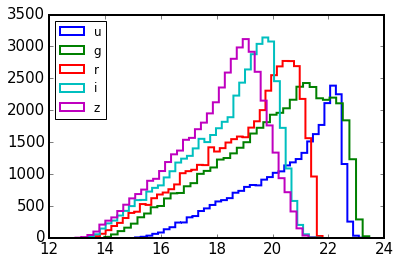

In [102]:
for l in 'ugriz' : 
    f = l+'_mMed'
    plt.hist(stars[f][(stars[f]>10)*(stars[f]<24)], histtype='step', lw=2, label=l, bins=40)
plt.legend(loc='upper left')

In [88]:
# Choose few CRTS stars....

bright_stars = stars[(stars['g_mMed'] < 16) * (stars['g_mMed'] > 15 ) ]

In [95]:
bright_stars.sort('raw_lc_length')
bright_long_stars  = bright_stars[::-1][:10]

In [112]:
faint_stars = stars[stars['g_mMed'] > 20]
faint_stars.sort('raw_lc_length')
faint_long_stars = faint_stars[::-1][:10]

Using 651 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/QSO_faint_235249.39-000629.4.png
Using 650 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/QSO_faint_234629.98-010825.5.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/QSO_faint_234648.39-010116.3.png
Using 635 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/QSO_faint_033931.15+011449.9.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/QSO_faint_234509.42-005506.7.png
Using 650 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/QSO_faint_233317.38-002303.4.png
Using 650 windows of w

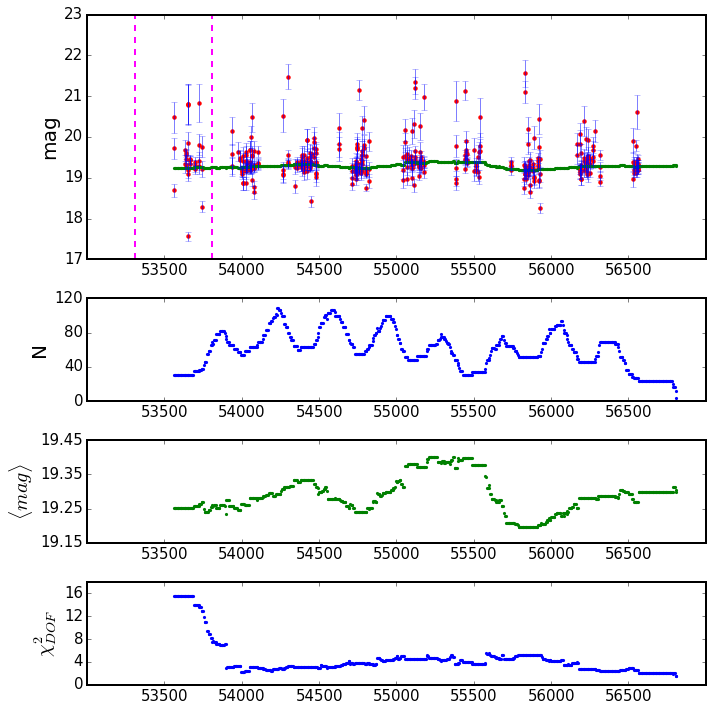

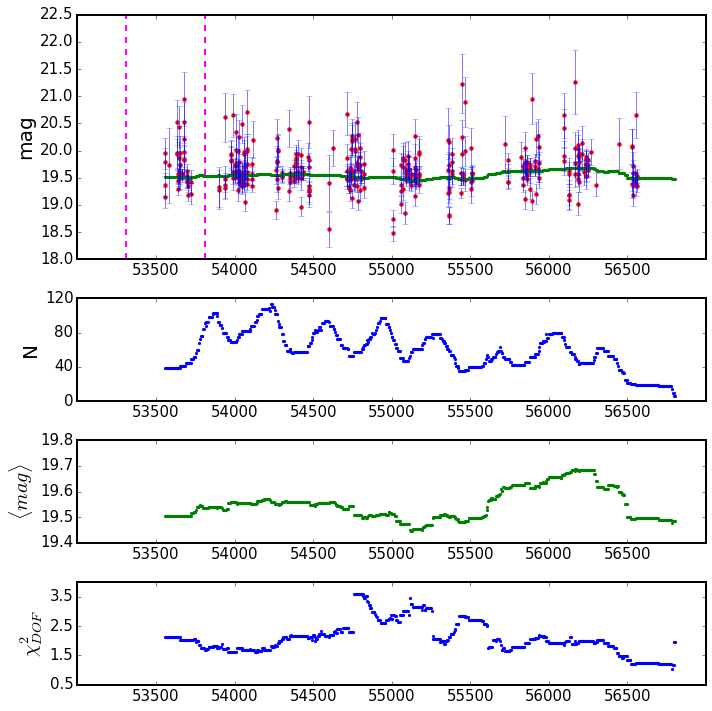

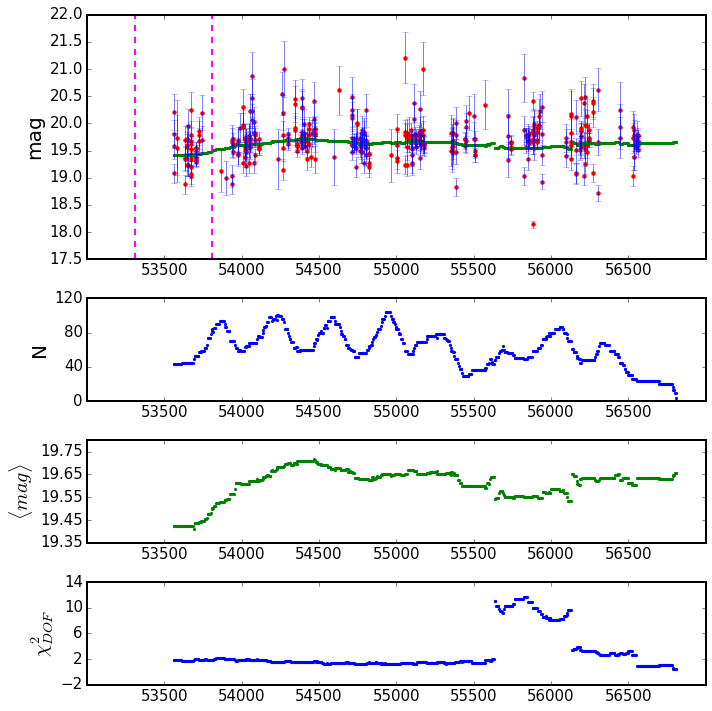

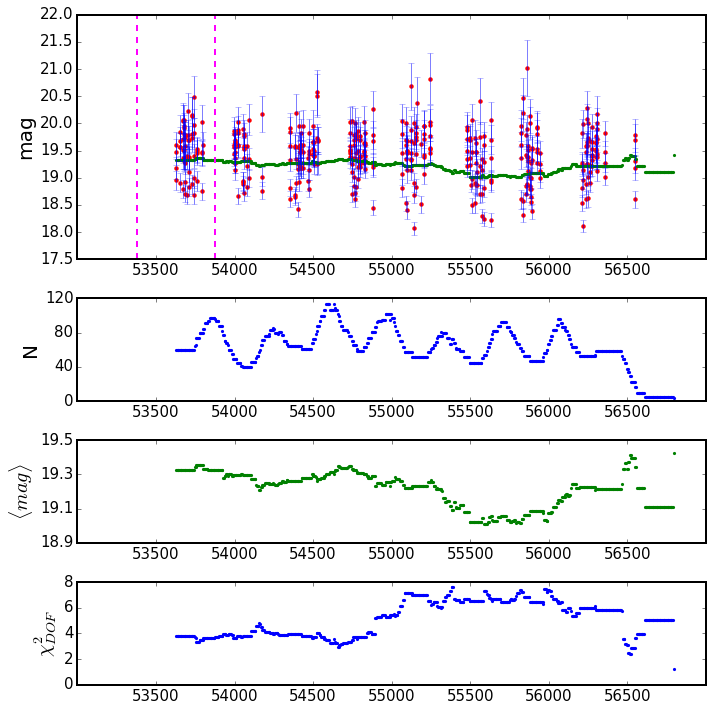

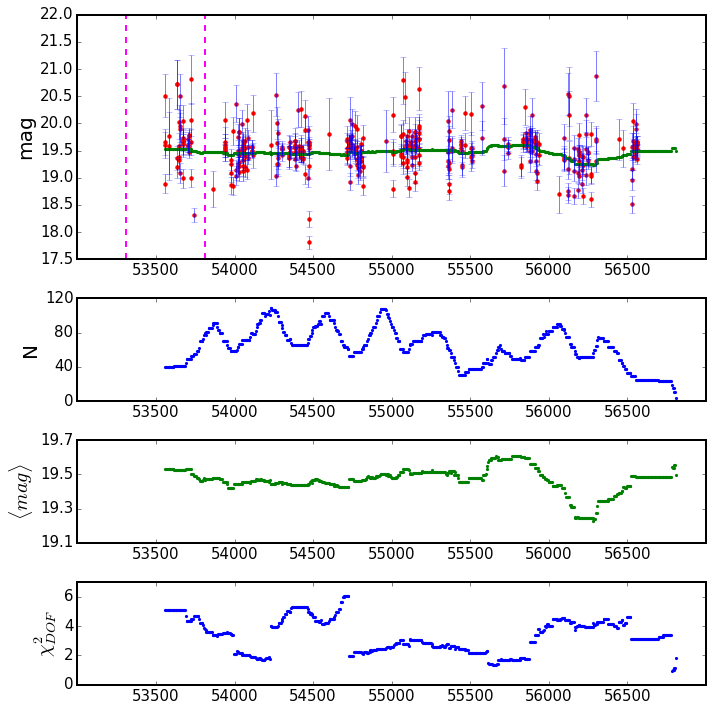

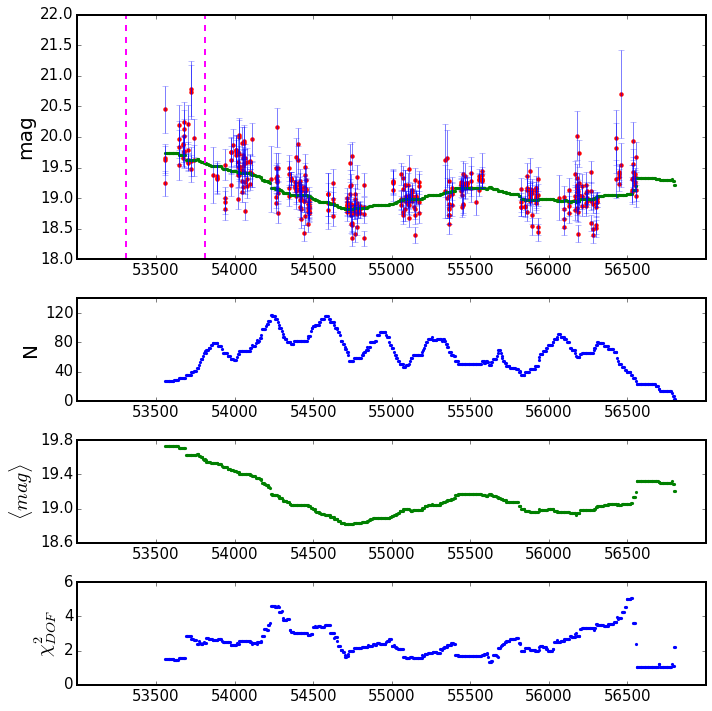

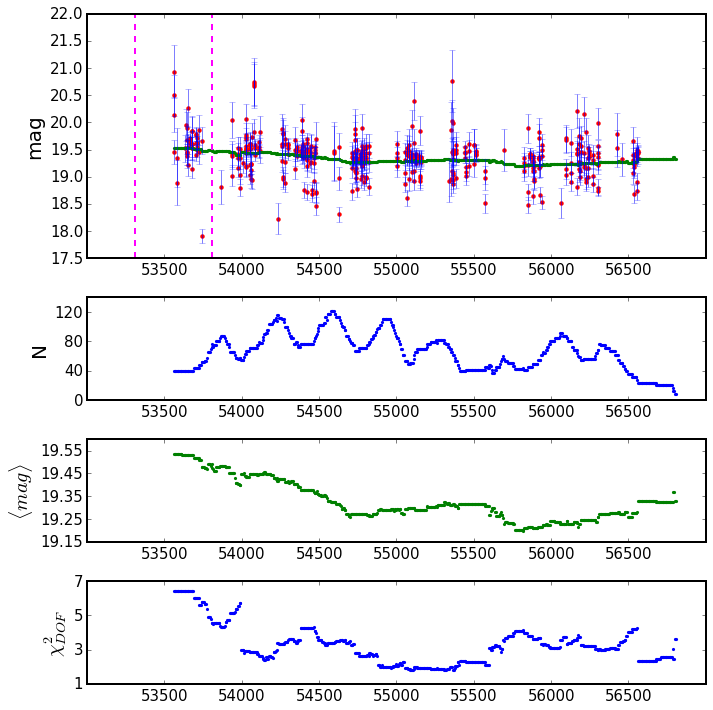

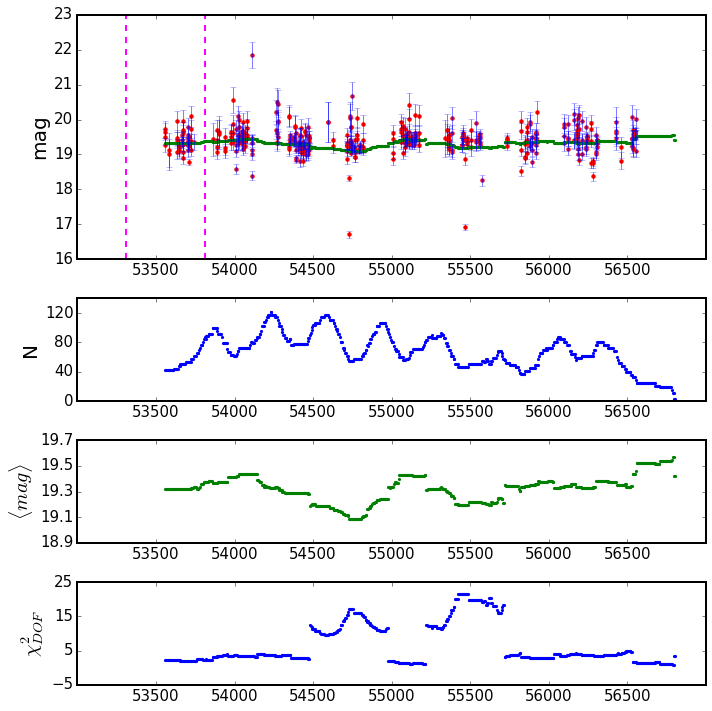

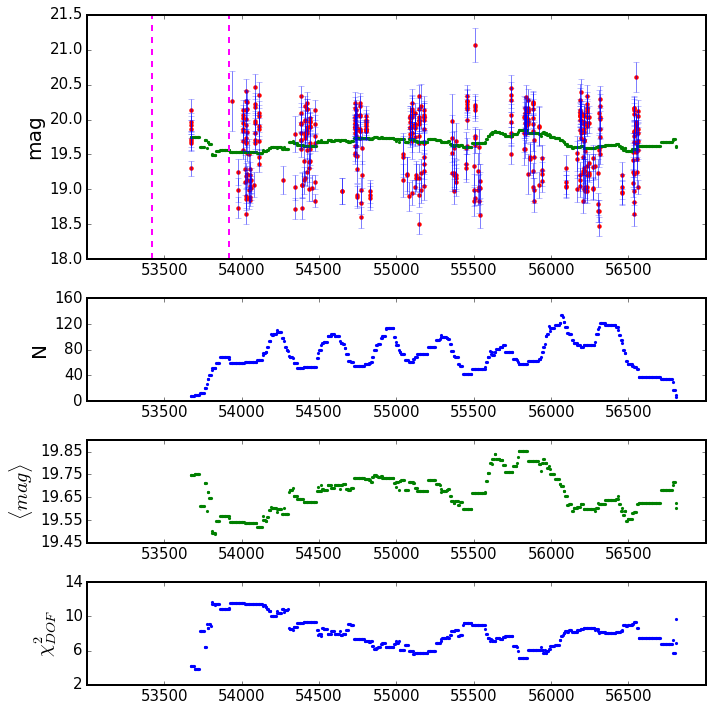

In [142]:
# plot the sliding_window_stats...


# Read-in the QSO lightcurves   : 
# faint QSO 
for i in range(len(faint_long_QSO)):
    lc_dir = '../raw_LC_CRTS/QSO_CRTS/' 
    qso_name = faint_long_QSO['CRTS_name'][i]
    address = lc_dir + qso_name+'.dat'
    data = Table.read(address, format='ascii')
    data.rename_column('col1', 'MJD')
    data.rename_column('col2', 'Mag')
    data.rename_column('col3', 'Magerr')
    data.sort('MJD')

    sliding_window_statistics(t = data['MJD'],y=data['Mag'],yerr=data['Magerr'], 
                              save_fig='Yes', fig_name='QSO_faint_'+qso_name+'.png')


Using 638 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/QSO_bright_031027.82-004950.7.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/QSO_bright_235156.12-010913.3.png


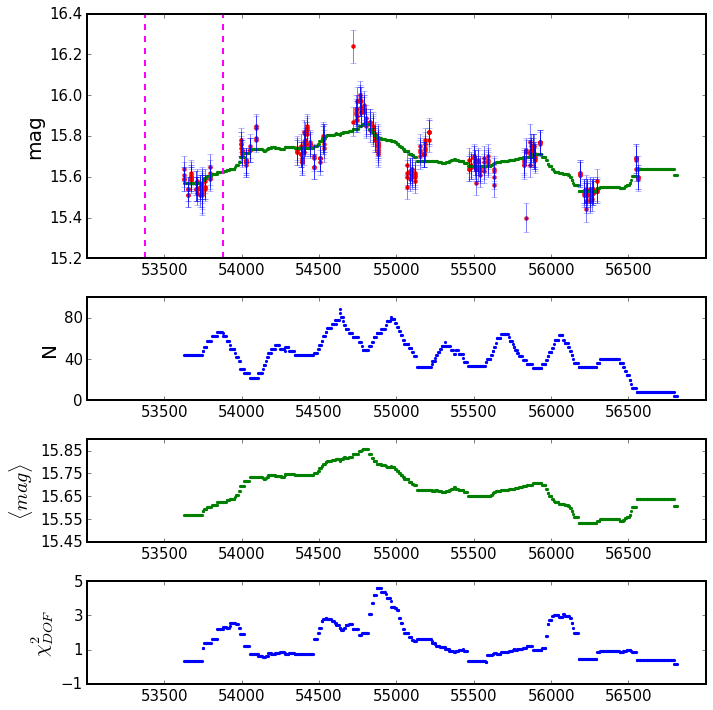

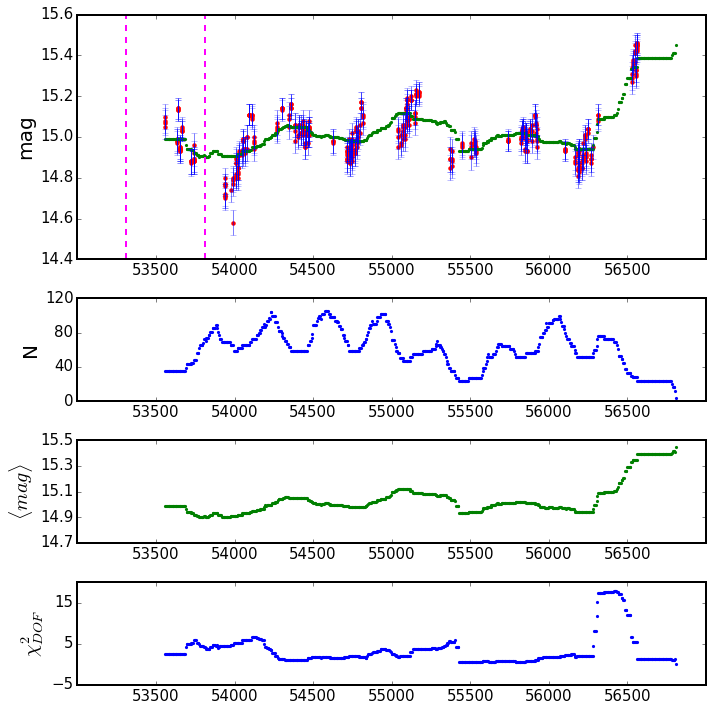

In [145]:
# Read-in the QSO lightcurves   : 
# bright QSO 
for i in range(len(bright_QSO)):
    lc_dir = '../raw_LC_CRTS/QSO_CRTS/' 
    qso_name = bright_QSO['CRTS_name'][i]
    address = lc_dir + qso_name+'.dat'
    data = Table.read(address, format='ascii')
    data.rename_column('col1', 'MJD')
    data.rename_column('col2', 'Mag')
    data.rename_column('col3', 'Magerr')
    data.sort('MJD')

    sliding_window_statistics(t = data['MJD'],y=data['Mag'],yerr=data['Magerr'], 
                              save_fig='Yes', fig_name='QSO_bright_'+qso_name+'.png')

In [152]:
import os 
import datetime
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_6_data',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('Saving todays work in %s'%outDir)

Saving todays work in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_6_data/2017-03-02/


Using 666 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_bright_569079.png
Using 667 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_bright_621665.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_bright_990287.png
Using 650 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_bright_986131.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_bright_987134.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_bright_990991.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days

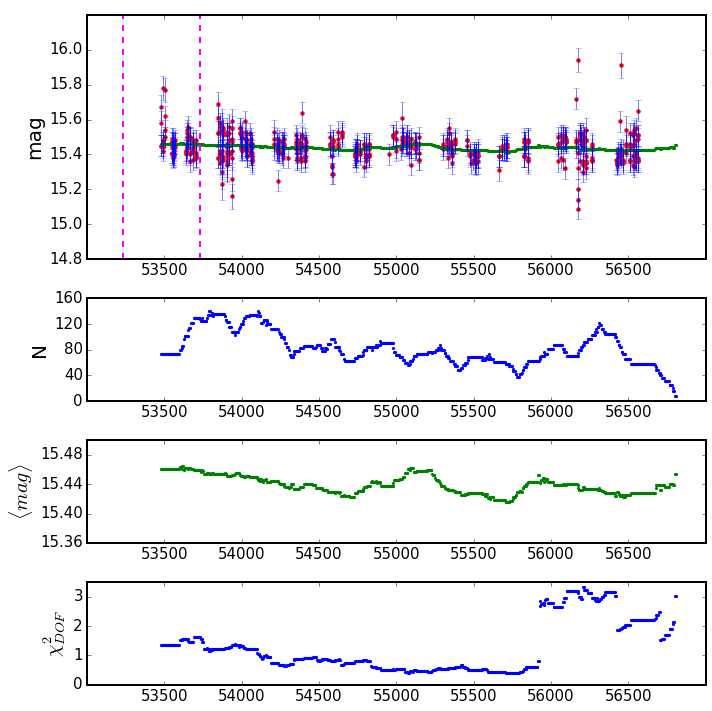

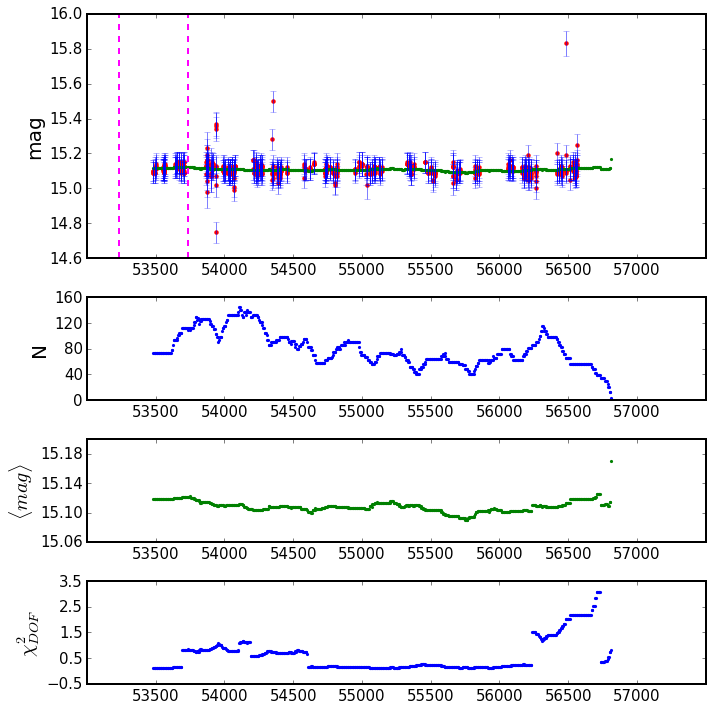

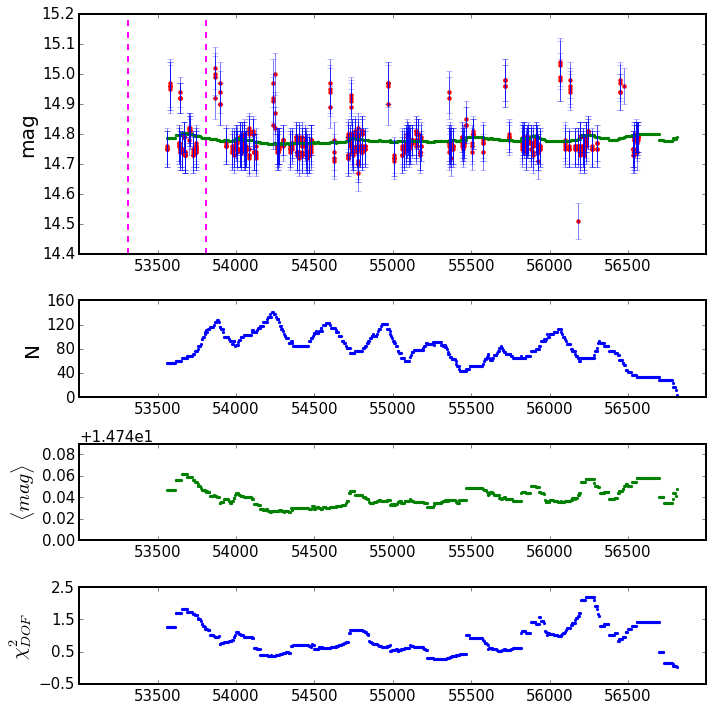

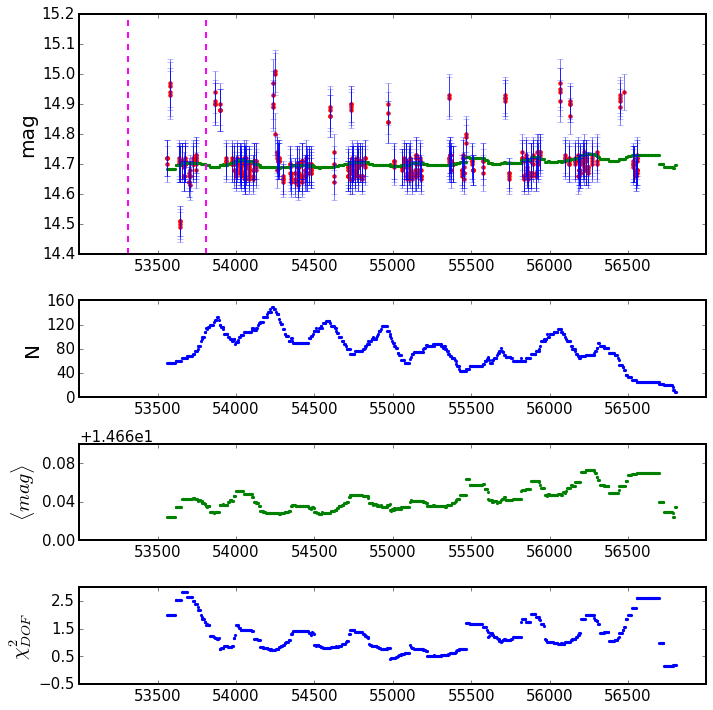

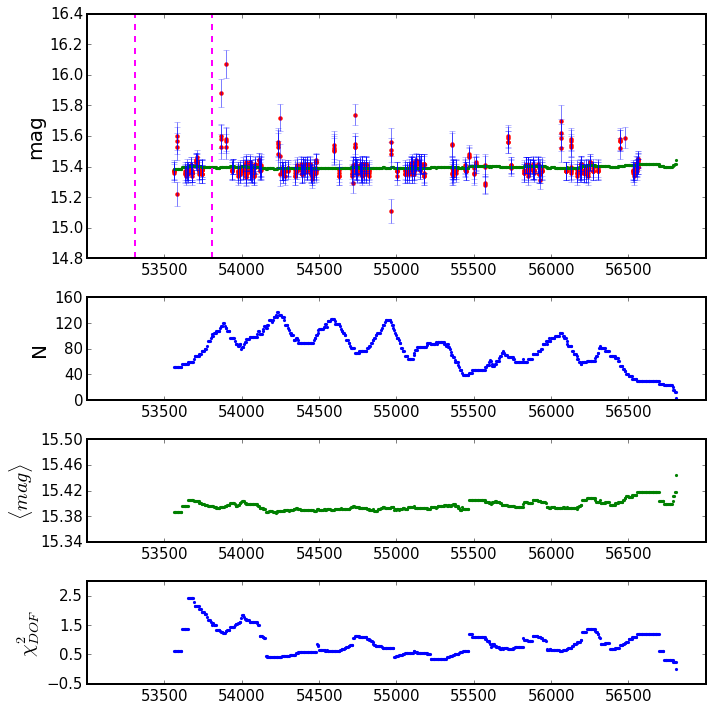

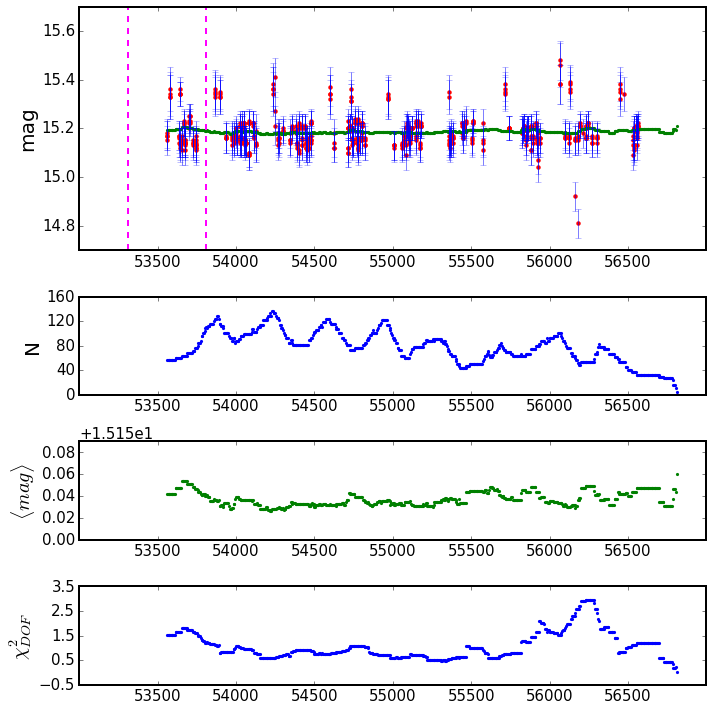

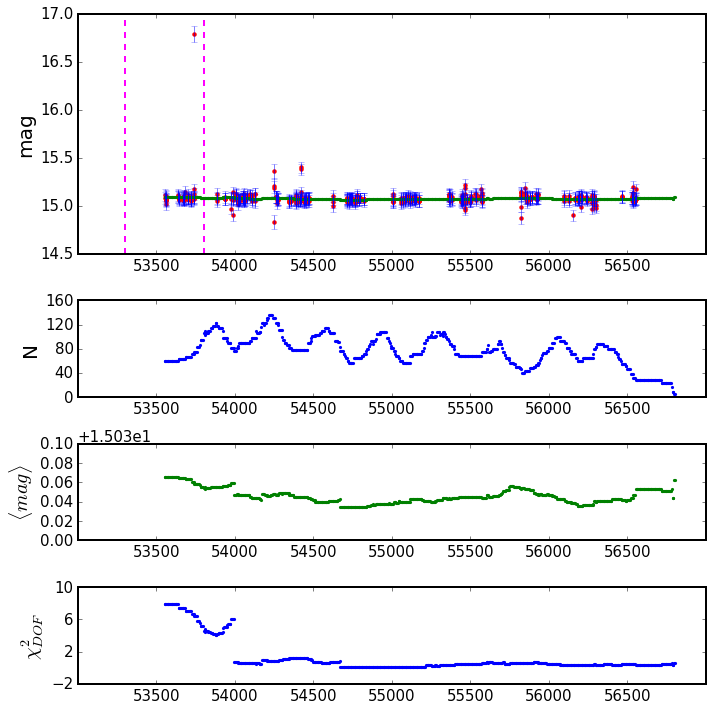

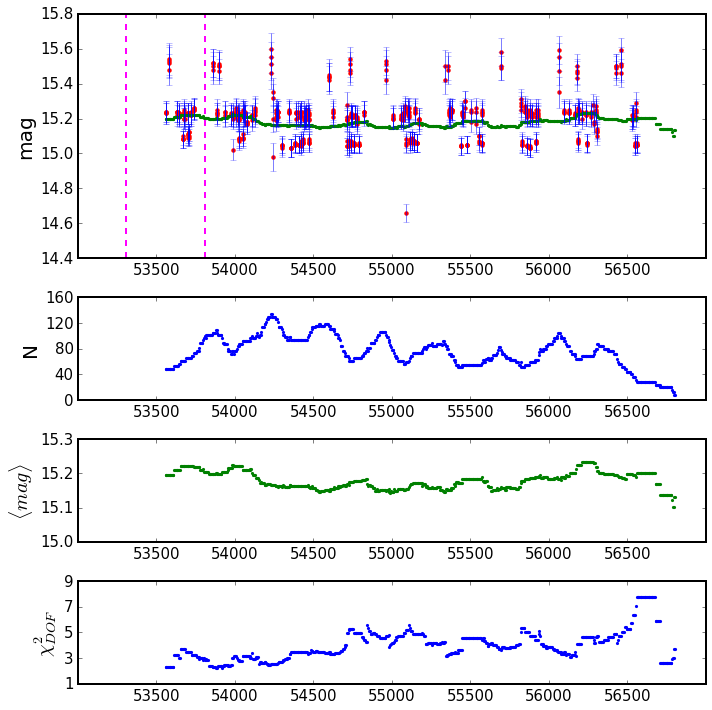

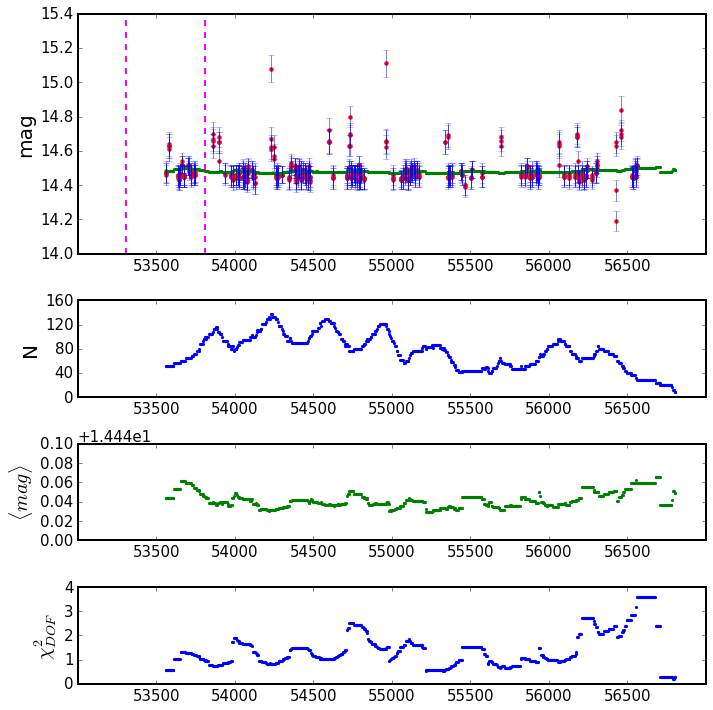

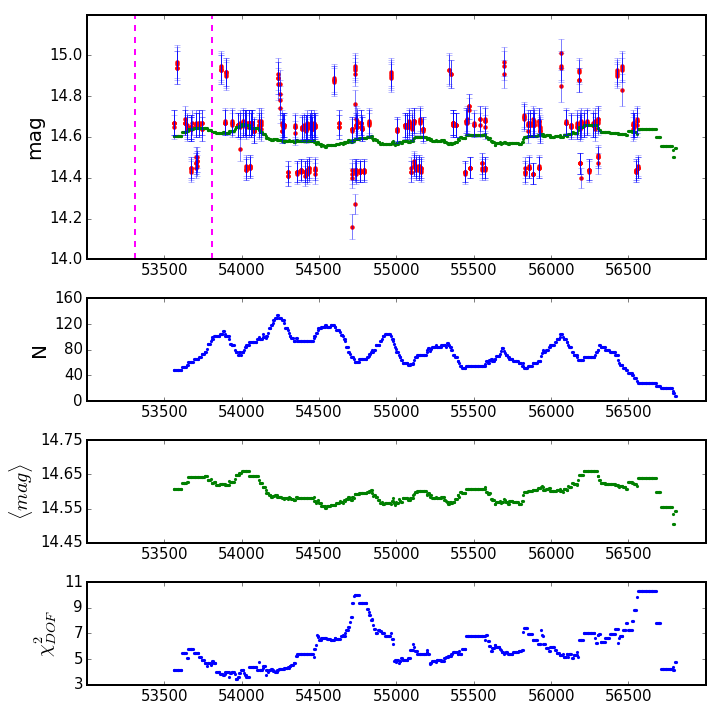

In [146]:
# Read in stellar lightcurve...


tab =  bright_long_stars
for i in range(len(tab)):
    lc_dir = '../raw_LC_CRTS/stars/' 
    name = str(tab['CRTS_name'][i]) # choose lightcurve from LC catalog 
    address = lc_dir + name+'.dat'
    data = Table.read(address, format='ascii') # read in the lightcurve 
    data.rename_column('col1', 'MJD')
    data.rename_column('col2', 'Mag')
    data.rename_column('col3', 'Magerr')
    data.sort('MJD')

    sliding_window_statistics(t = data['MJD'],y=data['Mag'],yerr=data['Magerr'], 
                              save_fig='Yes', fig_name='star_bright_'+name+'.png')


    

Using 667 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_faint_575688.png
Using 667 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_faint_639239.png
Using 667 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_faint_698292.png
Using 651 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_faint_987688.png
Using 650 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_faint_971892.png
Using 650 windows of width 500 days each , with the window sliding step of  5 days
Saved this plot as ../data_products/Fig_6_data/star_faint_990368.png
Using 666 windows of width 500 days each , with the window sliding step of  5 days
Saved

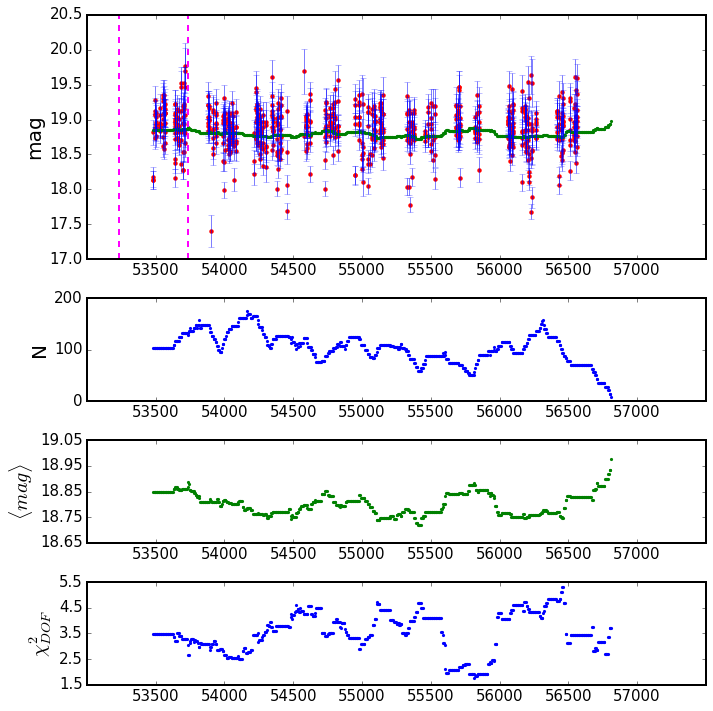

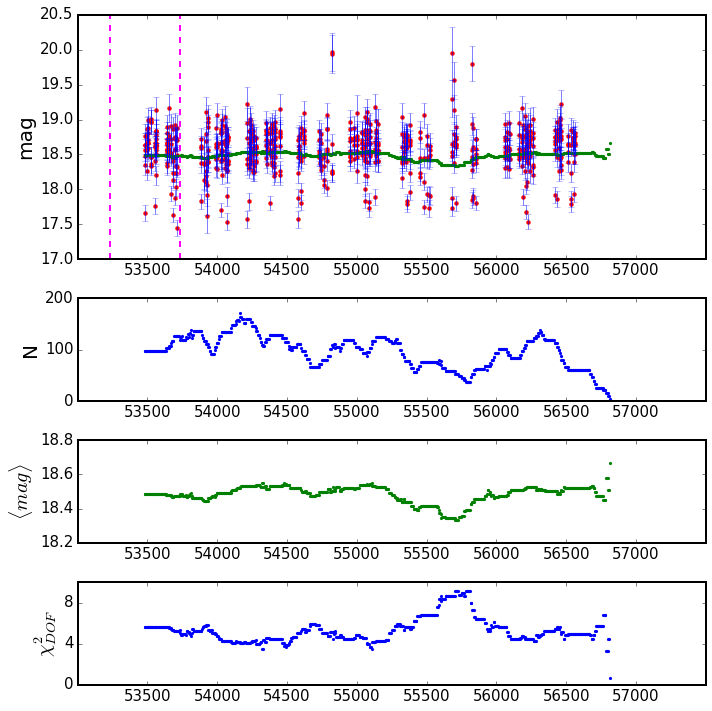

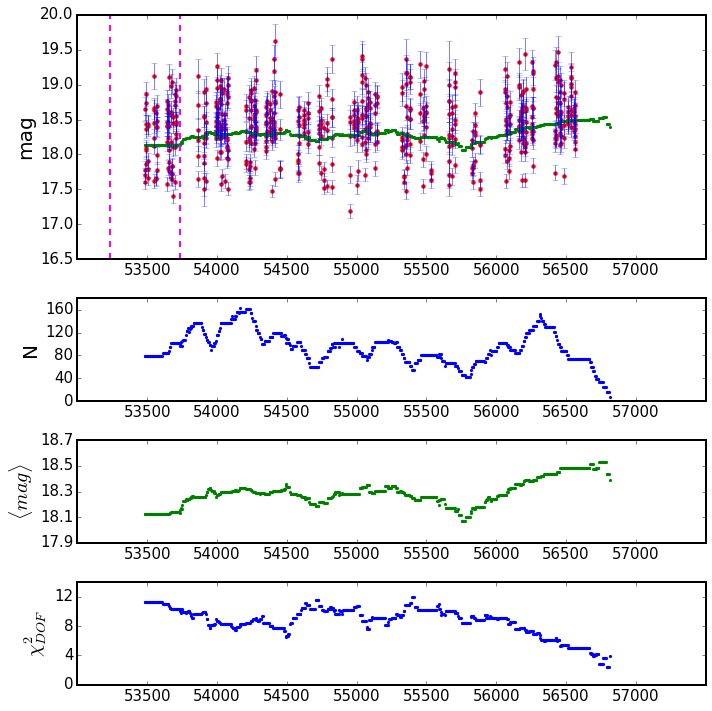

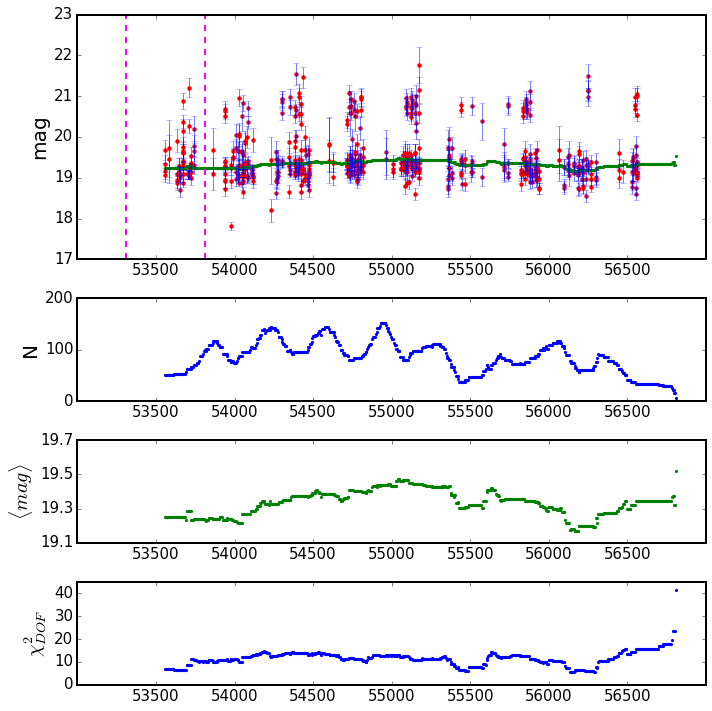

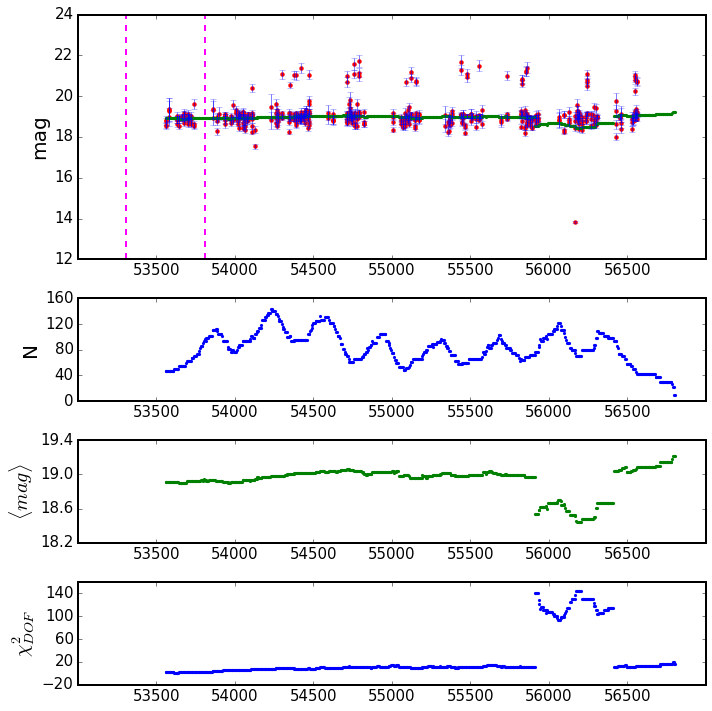

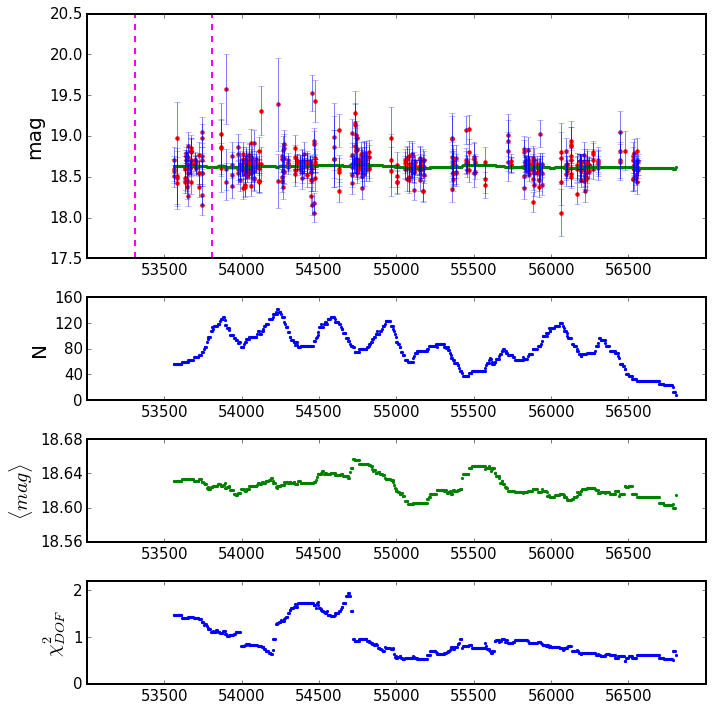

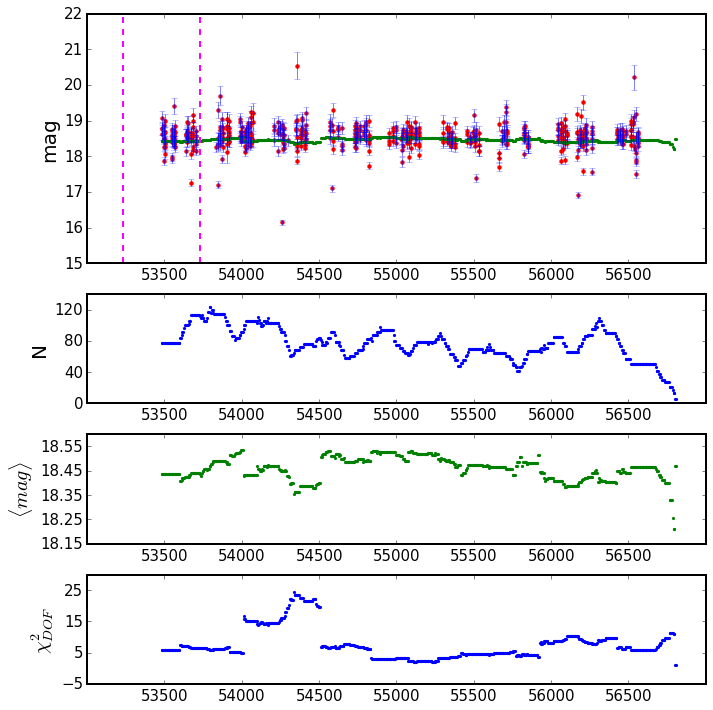

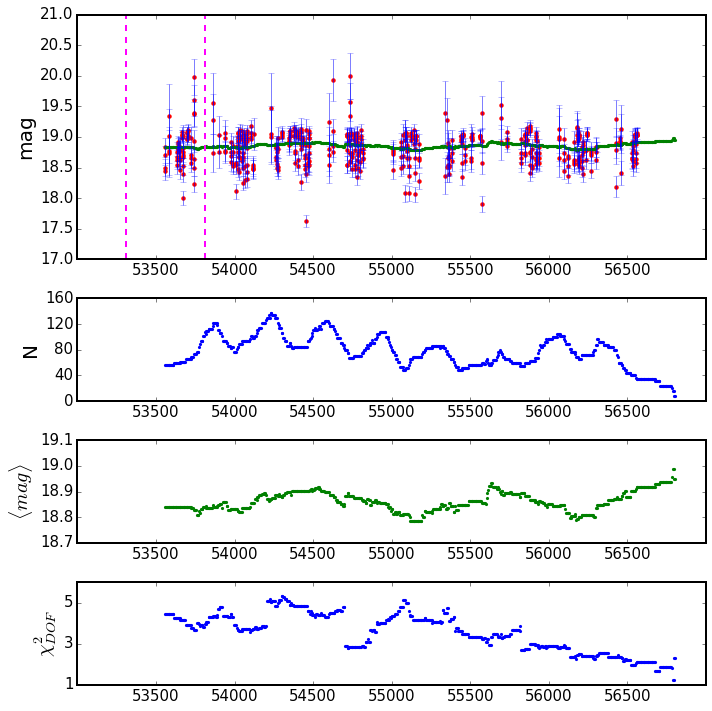

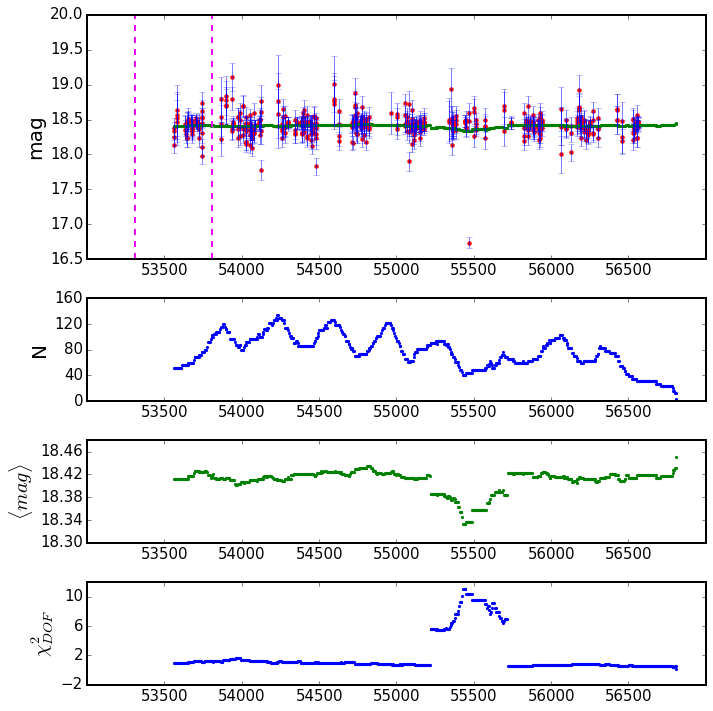

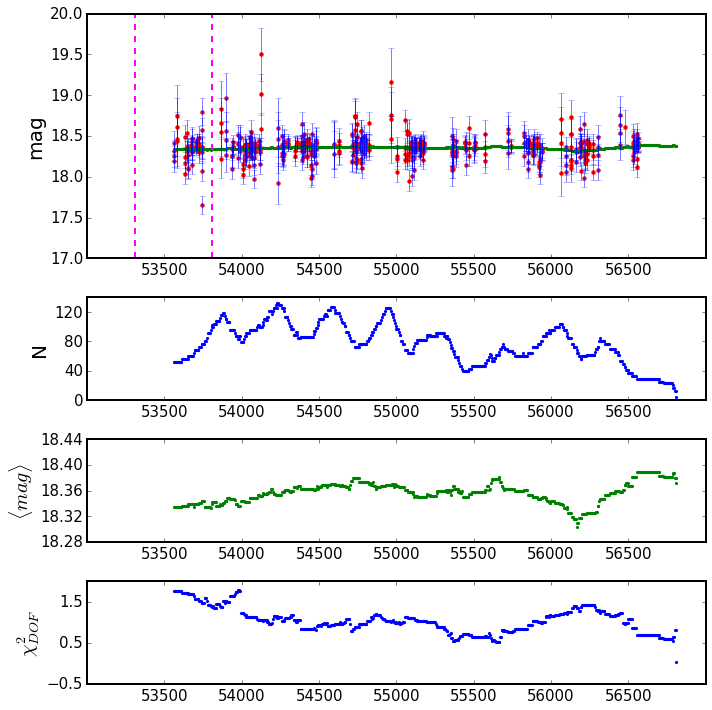

In [147]:
# Read in stellar lightcurve...


tab =  faint_long_stars
for i in range(len(tab)):
    lc_dir = '../raw_LC_CRTS/stars/' 
    name = str(tab['CRTS_name'][i]) # choose lightcurve from LC catalog 
    address = lc_dir + name+'.dat'
    data = Table.read(address, format='ascii') # read in the lightcurve 
    data.rename_column('col1', 'MJD')
    data.rename_column('col2', 'Mag')
    data.rename_column('col3', 'Magerr')
    data.sort('MJD')

    sliding_window_statistics(t = data['MJD'],y=data['Mag'],yerr=data['Magerr'], 
                              save_fig='Yes', fig_name='star_faint_'+name+'.png')


    